In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize_scalar
from pythermalcomfort.models import pmv
from pythermalcomfort.models import set_tmp

## Data Preparation

### Import ASHRAE Global Thermal Comfort Database 2

In [4]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

# Merge building metadata and measurement data
df_rawdata = df_measurements.merge(df_meta[['building_id', 'city', 'building_type', 'cooling_type', 'records', 'database']], on='building_id', how='left')

print('Total buildings:', len(df_rawdata.building_id.unique()))
print('Total records:', len(df_rawdata))

Total buildings: 809
Total records: 109033


/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_49455/1041017263.py:7: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_measurements = pd.read_csv(url_measurements)


### Clean outdoor air temperature data

In [5]:
# Merge two outdoor air temperature columns as a new column
df_rawdata.loc[:, 't_out_combined'] = df_rawdata.loc[:, 't_out_isd'].fillna(df_rawdata.loc[:, 't_out'])

# Remove the two outdoor air temperature columns
df_rawdata = df_rawdata.drop(columns=['t_out_isd', 't_out'])

### A dataframe with each occupant as a row, simultaniouely having Tout, Top, and TSV data

In [6]:
# Keep rows that simultaneously have data for all variables in cols 
def filter(df, cols):
    df_qualifed = df.dropna(subset=cols)
    print(f'Qualified buildings:', len(df_qualifed['building_id'].unique()))
    print(f'Qualified records:', len(df_qualifed))
    return df_qualifed

# Keep rows that simultaneously have data for all variables in cols
cols_1 = ['t_out_combined', 'top', 'set', 'thermal_sensation']
df_data_1 = filter(df_rawdata, cols_1).copy()
df_data_1.head()

Qualified buildings: 518
Qualified records: 26307


,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,ppd,pmv_ce,ppd_ce,t_mot_isd,city,building_type,cooling_type,records,database,t_out_combined
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,10.2,0.38,8.0,17.4,sydney,office,mixed mode,170,1.0,16.295833
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,8.4,0.40,8.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,5.1,-0.07,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,7.0,0.14,5.4,17.4,sydney,office,mixed mode,170,1.0,16.295833
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,5.0,-0.06,5.1,17.4,sydney,office,mixed mode,170,1.0,16.295833


## First stage: neutral temperature estimation

### Define functions for estimating neutral temperature for a building

In [7]:
# regress TSV against Top (metric used in existing AHRAE ACM)
def approach_op_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ top', data=bldg).fit()
        slope = lm_result.params['top']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['top'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress Top against TSV  
def approach_op_b(bldg):
    try:
        lm_result = smf.ols(formula='top ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan
    
# regress TSV against SET (a new metric)
def approach_SET_a(bldg):
    try:
        lm_result = smf.ols(formula='thermal_sensation ~ set', data=bldg).fit()
        slope = lm_result.params['set']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['set'] < 0.05:
            a = slope
            b = intercept
            temp_n = -b / a
            temp_up = (0.85-b)/a
            temp_low = (-0.85-b)/a
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

# regress SET against TSV  
def approach_SET_b(bldg):
    try:
        lm_result = smf.ols(formula='set ~ thermal_sensation', data=bldg).fit()
        slope = lm_result.params['thermal_sensation']
        intercept = lm_result.params['Intercept']
        # check whether the slope is significant
        if lm_result.pvalues['thermal_sensation'] < 0.05:
            a = slope
            b = intercept
            temp_n = b
            temp_up = 0.85*a + b
            temp_low = (-0.85)*a + b
            return [slope, intercept, temp_n, temp_up, temp_low]
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

### A dataframe with each building as a row, to store the first stage result

In [8]:
# Define the columns for which you want to calculate the mean
mean_cols = ['t_out_combined', 'top', 'set', 'thermal_sensation']

# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data_1.groupby('building_id')[mean_cols].mean()

# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)

# Merge df_means with the metadata
df_bldg_1 = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')

# Reset the building cooling type as string
df_bldg_1['cooling_type'] = df_bldg_1['cooling_type'].str.title()

### Estimate neutral temperature (top) for each single building

In [26]:
# store regression results as columns
columns_name = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']

# calculate regression results for each building
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg_1[column] = df_data_1.groupby('building_id').apply(lambda x: approach_op_a(x)[i] if approach_op_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg_1[column] = df_data_1.groupby('building_id').apply(lambda x: approach_op_b(x)[i] if approach_op_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg_1.head()

,building_id,t_out_combined,top,set,thermal_sensation,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
0,1,15.560695,23.360524,25.454225,0.661972,170,Mixed Mode,office,1.0,0.282810,0.708579,-5.944612,22.891465,21.019827,22.891465,24.025381,23.493757,18.014273,22.289173
1,2,13.995833,22.328590,23.616000,0.020000,83,Air Conditioned,office,1.0,0.643948,0.292102,-14.358447,22.322748,22.297532,22.322748,23.617515,22.571035,20.977549,22.074462
2,3,0.583480,23.178237,23.694118,0.252941,85,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,19.225391,23.936241,24.164706,0.075630,137,Mixed Mode,office,1.0,0.478756,0.462422,-11.383983,23.901268,23.778269,23.901268,25.553704,24.294327,22.002833,23.508209
4,5,9.048210,22.095310,22.271875,-0.063281,128,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Second stage: ACM

### Filter out non-signficant regression results

In [27]:
# number of all buildings
print('Total buildings:', len(df_bldg_1))
print("Total NV buildings:", len(df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated']))
print("Total AC buildings:", len(df_bldg_1[df_bldg_1['cooling_type'] == 'Air Conditioned']))
df_bldg_1_NV_office = df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated'][df_bldg_1['building_type'] == 'office'].copy()
print("Total NV Office buildings:", len(df_bldg_1_NV_office))

# get rid of all nan values in the temp_n_a column
df_bldg_1_sig_a = df_bldg_1[~df_bldg_1['temp_n_a'].isna()]
# print("******************************************************************************")
# # print the number of buildings that have negative slopes
# print('Total negative signifiant buildings:', df_bldg_1[df_bldg_1['slope_a']<0].building_id.nunique())


df_bldg_1_NV_a = df_bldg_1_sig_a[df_bldg_1_sig_a['cooling_type'] == 'Naturally Ventilated']
df_bldg_1_AC_a = df_bldg_1_sig_a[df_bldg_1_sig_a['cooling_type'] == 'Air Conditioned']
df_bldg_1_office_NV_a = df_bldg_1_NV_a[df_bldg_1_NV_a['building_type'] == 'office'].copy()
df_bldg_1_office_AC_a = df_bldg_1_AC_a[df_bldg_1_AC_a['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (a)')
print('Total signficant buildings:', len(df_bldg_1_sig_a))
print('Total signficant NV buildings:', len(df_bldg_1_NV_a))
print('Total signficant NV office buildings:', len(df_bldg_1_office_NV_a))
print('Total signficant AC buildings:', len(df_bldg_1_AC_a))
print('Total signficant AC office buildings:', len(df_bldg_1_office_AC_a))

# get rid of all nan values in the temp_n_a column
df_bldg_1_sig_b = df_bldg_1[~df_bldg_1['temp_n_b'].isna()]
df_bldg_1_NV_b = df_bldg_1_sig_b[df_bldg_1_sig_b['cooling_type'] == 'Naturally Ventilated']
df_bldg_1_AC_b = df_bldg_1_sig_b[df_bldg_1_sig_b['cooling_type'] == 'Air Conditioned']
df_bldg_1_office_AC_b = df_bldg_1_AC_b[df_bldg_1_AC_b['building_type'] == 'office'].copy()
df_bldg_1_office_NV_b = df_bldg_1_NV_b[df_bldg_1_NV_b['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (b)')
print('Total signficant buildings:', len(df_bldg_1_sig_b))
print('Total signficant NV buildings:', len(df_bldg_1_NV_b))
print('Total signficant NV office buildings:', len(df_bldg_1_office_NV_b))
print('Total signficant AC buildings:', len(df_bldg_1_AC_b))
print('Total signficant AC office buildings:', len(df_bldg_1_office_AC_b))

Total buildings: 518
Total NV buildings: 197
Total AC buildings: 153
Total NV Office buildings: 55
******************************************************************************
Approach (a)
Total signficant buildings: 184
Total signficant NV buildings: 61
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74
******************************************************************************
Approach (b)
Total signficant buildings: 198
Total signficant NV buildings: 67
Total signficant NV office buildings: 41
Total signficant AC buildings: 74
Total signficant AC office buildings: 74


<ipython-input-27-335001f4fbb6>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bldg_1_NV_office = df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated'][df_bldg_1['building_type'] == 'office'].copy()


### Define a weighted linear regression

In [9]:
# Weighted regression function
def weighted_regression(x, y, weights):
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()
    intercept, slope = model.params
    print('p value {:.3f}'.format(model.pvalues[1]))
    print(model.summary())
    return intercept, slope

### ACM (op) for all NV offices

In [68]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_op_NV_a = df_bldg_1_office_NV_a[(df_bldg_1_office_NV_a['t_out_combined'] >= 10) & (df_bldg_1_office_NV_a['t_out_combined'] <= 33.5)]
df_ACM_op_NV_b = df_bldg_1_office_NV_b[(df_bldg_1_office_NV_b['t_out_combined'] >= 10) & (df_bldg_1_office_NV_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_NV:", len(df_ACM_op_NV_a))
print("Total buildings for Approach (b) ACM_NV:", len(df_ACM_op_NV_b))

Total buildings for Approach (a) ACM_NV: 39
Total buildings for Approach (b) ACM_NV: 39


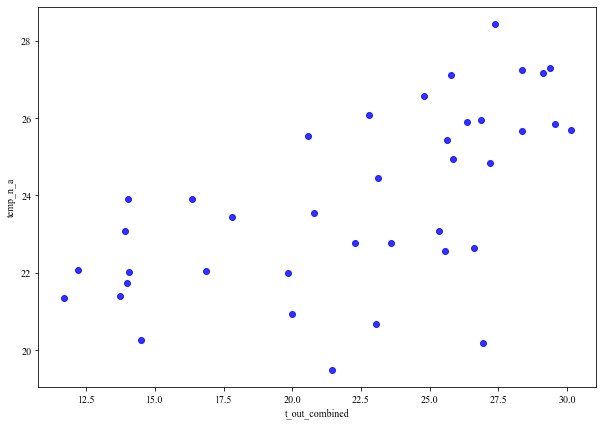

In [52]:
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_op_NV_a, fit_reg=False, scatter_kws={'color': 'blue'})
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

#### Approach (a)

In [69]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_op_NV_a['t_out_combined'], df_ACM_op_NV_a['temp_n_a'], df_ACM_op_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_op_NV_a['temp_up_a'].mean() - df_ACM_op_NV_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.407
Model:                            WLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     25.35
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           1.27e-05
Time:                        12:12:55   Log-Likelihood:                -83.089
No. Observations:                  39   AIC:                             170.2
Df Residuals:                      37   BIC:                             173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3442     

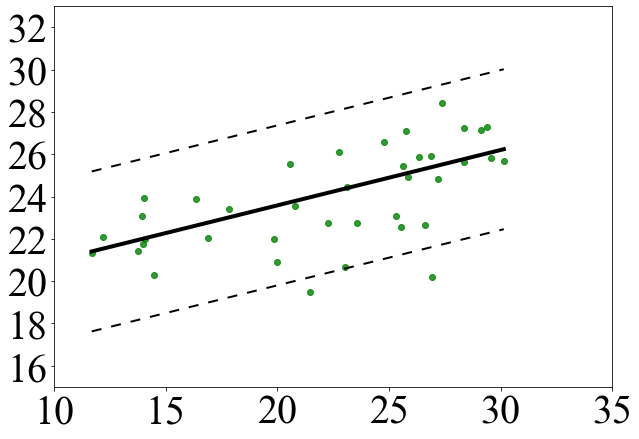

In [77]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_op_NV_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_op_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig3_a.pdf', format='pdf', bbox_inches='tight')


Accuracy

In [31]:
# # create a new dataframe from df_data, that has all building id in df_bldg_1_NV_office_op_a_a
# df_data_nv_a = df_data_1[df_data_1['building_id'].isin(df_ACM_op_NV_a['building_id'])].copy()
# df_data_nv_a['up_limit'] = temp_n_a_slope * df_data_nv_a['t_out_combined'] + temp_n_a_intercept + range_a/2
# df_data_nv_a['low_limit'] = temp_n_a_slope * df_data_nv_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_nv_a['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_nv_a['thermal_sensation'] >= -0.85) & 
#      (df_data_nv_a['thermal_sensation'] <= 0.85) & 
#      (df_data_nv_a['top'] >= df_data_nv_a['low_limit']) & 
#      (df_data_nv_a['top'] <= df_data_nv_a['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_nv_a['thermal_sensation'] < -0.85) | 
#      (df_data_nv_a['thermal_sensation'] > 0.85)) & 
#      ((df_data_nv_a['top'] < df_data_nv_a['low_limit']) | 
#       (df_data_nv_a['top'] > df_data_nv_a['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy on statistically significant NV buildings: {:.0f} %'.format(len(df_data_nv_a[df_data_nv_a['accurate_prediction'] == 1])/len(df_data_nv_a)*100))


# create a new dataframe from df_data, that has all building id in 
df_data_NV_office_op_a = df_data_1[df_data_1['building_id'].isin(df_bldg_1_NV_office['building_id'])].copy()
df_data_NV_office_op_a['up_limit'] = temp_n_a_slope * df_data_NV_office_op_a['t_out_combined'] + temp_n_a_intercept + range_a/2
df_data_NV_office_op_a['low_limit'] = temp_n_a_slope * df_data_NV_office_op_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_NV_office_op_a['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_NV_office_op_a['thermal_sensation'] >= -0.85) & 
     (df_data_NV_office_op_a['thermal_sensation'] <= 0.85) & 
     (df_data_NV_office_op_a['top'] >= df_data_NV_office_op_a['low_limit']) & 
     (df_data_NV_office_op_a['top'] <= df_data_NV_office_op_a['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_NV_office_op_a['thermal_sensation'] < -0.85) | 
     (df_data_NV_office_op_a['thermal_sensation'] > 0.85)) & 
     ((df_data_NV_office_op_a['top'] < df_data_NV_office_op_a['low_limit']) | 
      (df_data_NV_office_op_a['top'] > df_data_NV_office_op_a['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_a = len(df_data_NV_office_op_a[df_data_NV_office_op_a['accurate_prediction'] == 1])/len(df_data_NV_office_op_a)
print('Prediction Accraucy of individual TSV on all NV buildings: {:.0f} %'.format(accuracy_a*100))


df_bldg_1_NV_office_op_a = df_bldg_1_NV_office.copy()
df_bldg_1_NV_office_op_a['up_limit'] = temp_n_a_slope * df_bldg_1_NV_office_op_a['t_out_combined'] + temp_n_a_intercept + range_a/2
df_bldg_1_NV_office_op_a['low_limit'] = temp_n_a_slope * df_bldg_1_NV_office_op_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_1_NV_office_op_a['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_1_NV_office_op_a['thermal_sensation'] >= -0.85) & 
     (df_bldg_1_NV_office_op_a['thermal_sensation'] <= 0.85) & 
     (df_bldg_1_NV_office_op_a['top'] >= df_bldg_1_NV_office_op_a['low_limit']) & 
     (df_bldg_1_NV_office_op_a['top'] <= df_bldg_1_NV_office_op_a['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_1_NV_office_op_a['thermal_sensation'] < -0.85) | 
     (df_bldg_1_NV_office_op_a['thermal_sensation'] > 0.85)) & 
     ((df_bldg_1_NV_office_op_a['top'] < df_bldg_1_NV_office_op_a['low_limit']) | 
      (df_bldg_1_NV_office_op_a['top'] > df_bldg_1_NV_office_op_a['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_b = len(df_bldg_1_NV_office_op_a[df_bldg_1_NV_office_op_a['accurate_prediction'] == 1])/len(df_bldg_1_NV_office_op_a)
print('Prediction Accraucy of mean TSV on all NV buildings: {:.0f} %'.format(accuracy_b*100))


# calculate the MSE and RMSE of the linear regression of n_temp_a on t_out_combined in df_ACM_op_NV_a
# calculate the predicted n_temp_a
df_ACM_op_NV_a['n_temp_a_predicted'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept
# calculate the residuals_a
df_ACM_op_NV_a['residuals_a'] = df_ACM_op_NV_a['temp_n_b'] - df_ACM_op_NV_a['n_temp_a_predicted']
# calculate the squared residuals_a
df_ACM_op_NV_a['squared_residuals_a'] = df_ACM_op_NV_a['residuals_a']**2
# calculate the MSE
MSE = df_ACM_op_NV_a['squared_residuals_a'].sum()/len(df_ACM_op_NV_a)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all NV buildings: 57 %
Prediction Accraucy of mean TSV on all NV buildings: 64 %
******************************************************************************
RMSE: 2.61


<ipython-input-31-337d9b7cfb67>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['n_temp_a_predicted'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept
<ipython-input-31-337d9b7cfb67>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['residuals_a'] = df_ACM_op_NV_a['temp_n_b'] - df_ACM_op_NV_a['n_temp_a_predicted']
<ipython-input-31-337d9b7cfb67>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Accuracy of mean TSV

In [19]:
# df_ACM_op_NV_a['up_limit'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept + range_a/2
# df_ACM_op_NV_a['low_limit'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_ACM_op_NV_a['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_ACM_op_NV_a['thermal_sensation'] >= -0.85) & 
#      (df_ACM_op_NV_a['thermal_sensation'] <= 0.85) & 
#      (df_ACM_op_NV_a['top'] >= df_ACM_op_NV_a['low_limit']) & 
#      (df_ACM_op_NV_a['top'] <= df_ACM_op_NV_a['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_ACM_op_NV_a['thermal_sensation'] < -0.85) | 
#      (df_ACM_op_NV_a['thermal_sensation'] > 0.85)) & 
#      ((df_ACM_op_NV_a['top'] < df_ACM_op_NV_a['low_limit']) | 
#       (df_ACM_op_NV_a['top'] > df_ACM_op_NV_a['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy of mean TSV on statistically significant NV buildings: {:.0f} %'.format(len(df_ACM_op_NV_a[df_ACM_op_NV_a['accurate_prediction'] == 1])/len(df_ACM_op_NV_a)*100))


Prediction Accraucy of mean TSV on statistically significant NV buildings: 69 %
Prediction Accraucy of mean TSV on all NV buildings: 51 %


<ipython-input-19-62e0cb6c816e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['up_limit'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept + range_a/2
<ipython-input-19-62e0cb6c816e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['low_limit'] = temp_n_a_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_a_intercept - range_a/2
<ipython-input-19-62e0cb6c816e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

#### Approach (b)

In [72]:
# conduct weighted ACM_NV regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_op_NV_b['t_out_combined'], df_ACM_op_NV_b['temp_n_b'], df_ACM_op_NV_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_op_NV_b['temp_up_b'].mean() - df_ACM_op_NV_b['temp_low_b'].mean()
print('ACM_NV comfort zone: {:.2f}'.format(range_b))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.835
Model:                            WLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     187.4
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           4.67e-16
Time:                        12:13:19   Log-Likelihood:                -73.198
No. Observations:                  39   AIC:                             150.4
Df Residuals:                      37   BIC:                             153.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.5774     

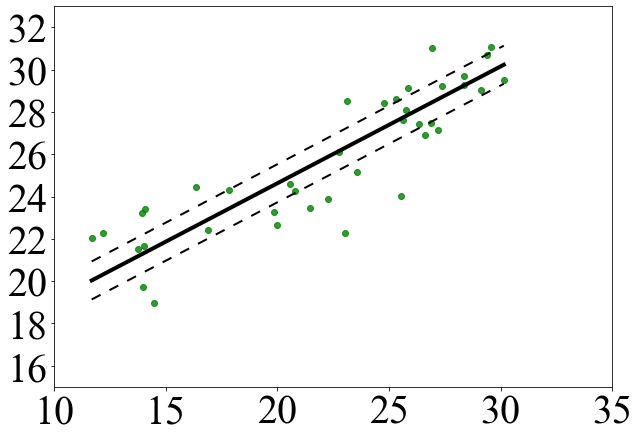

In [78]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_op_NV_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_op_NV_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(15, 33)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig3_b.pdf', format='pdf', bbox_inches='tight')

Accuracy

In [34]:
# # create a new dataframe from df_data, that has all building id in df_bldg_1_NV_office_op_b_b
# df_data_nv_b = df_data_1[df_data_1['building_id'].isin(df_ACM_op_NV_b['building_id'])].copy()
# df_data_nv_b['up_limit'] = temp_n_b_slope * df_data_nv_b['t_out_combined'] + temp_n_b_intercept + range_b/2
# df_data_nv_b['low_limit'] = temp_n_b_slope * df_data_nv_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_nv_b['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_nv_b['thermal_sensation'] >= -0.85) & 
#      (df_data_nv_b['thermal_sensation'] <= 0.85) & 
#      (df_data_nv_b['top'] >= df_data_nv_b['low_limit']) & 
#      (df_data_nv_b['top'] <= df_data_nv_b['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_nv_b['thermal_sensation'] < -0.85) | 
#      (df_data_nv_b['thermal_sensation'] > 0.85)) & 
#      ((df_data_nv_b['top'] < df_data_nv_b['low_limit']) | 
#       (df_data_nv_b['top'] > df_data_nv_b['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy: {:.0f} %'.format(len(df_data_nv_b[df_data_nv_b['accurate_prediction'] == 1])/len(df_data_nv_b)*100))


df_data_NV_office_op_b = df_data_1[df_data_1['building_id'].isin(df_bldg_1_NV_office['building_id'])].copy()
df_data_NV_office_op_b['up_limit'] = temp_n_b_slope * df_data_NV_office_op_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_data_NV_office_op_b['low_limit'] = temp_n_b_slope * df_data_NV_office_op_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_NV_office_op_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_NV_office_op_b['thermal_sensation'] >= -0.85) & 
     (df_data_NV_office_op_b['thermal_sensation'] <= 0.85) & 
     (df_data_NV_office_op_b['top'] >= df_data_NV_office_op_b['low_limit']) & 
     (df_data_NV_office_op_b['top'] <= df_data_NV_office_op_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_NV_office_op_b['thermal_sensation'] < -0.85) | 
     (df_data_NV_office_op_b['thermal_sensation'] > 0.85)) & 
     ((df_data_NV_office_op_b['top'] < df_data_NV_office_op_b['low_limit']) | 
      (df_data_NV_office_op_b['top'] > df_data_NV_office_op_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_a = len(df_data_NV_office_op_b[df_data_NV_office_op_b['accurate_prediction'] == 1])/len(df_data_NV_office_op_b)
print('Prediction Accraucy of individual TSV on all NV office buildings: {:.0f} %'.format(accuracy_a*100))


df_bldg_1_NV_office_op_b = df_bldg_1_NV_office.copy()
df_bldg_1_NV_office_op_b['up_limit'] = temp_n_b_slope * df_bldg_1_NV_office_op_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_bldg_1_NV_office_op_b['low_limit'] = temp_n_b_slope * df_bldg_1_NV_office_op_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_1_NV_office_op_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_1_NV_office_op_b['thermal_sensation'] >= -0.85) & 
     (df_bldg_1_NV_office_op_b['thermal_sensation'] <= 0.85) & 
     (df_bldg_1_NV_office_op_b['top'] >= df_bldg_1_NV_office_op_b['low_limit']) & 
     (df_bldg_1_NV_office_op_b['top'] <= df_bldg_1_NV_office_op_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_1_NV_office_op_b['thermal_sensation'] < -0.85) | 
     (df_bldg_1_NV_office_op_b['thermal_sensation'] > 0.85)) & 
     ((df_bldg_1_NV_office_op_b['top'] < df_bldg_1_NV_office_op_b['low_limit']) | 
      (df_bldg_1_NV_office_op_b['top'] > df_bldg_1_NV_office_op_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_b = len(df_bldg_1_NV_office_op_b[df_bldg_1_NV_office_op_b['accurate_prediction'] == 1])/len(df_bldg_1_NV_office_op_b)
print('Prediction Accraucy of mean TSV on all NV office buildings: {:.0f} %'.format(accuracy_b*100))



# calculate the MSE and RMSE of the linear regression of n_temp_b on t_out_combined in df_ACM_op_NV_b
# calculate the predicted n_temp_b
df_ACM_op_NV_b['n_temp_b_predicted'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept
# calculate the residuals_b
df_ACM_op_NV_b['residuals_b'] = df_ACM_op_NV_b['temp_n_b'] - df_ACM_op_NV_b['n_temp_b_predicted']
# calculate the squared residuals_b
df_ACM_op_NV_b['squared_residuals_b'] = df_ACM_op_NV_b['residuals_b']**2
# calculate the MSE
MSE = df_ACM_op_NV_b['squared_residuals_b'].sum()/len(df_ACM_op_NV_b)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))




Prediction Accraucy of individual TSV on all NV office buildings: 56 %
Prediction Accraucy of mean TSV on all NV office buildings: 42 %
******************************************************************************
RMSE: 1.60


<ipython-input-34-237bbd611763>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_b['n_temp_b_predicted'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept
<ipython-input-34-237bbd611763>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_b['residuals_b'] = df_ACM_op_NV_b['temp_n_b'] - df_ACM_op_NV_b['n_temp_b_predicted']
<ipython-input-34-237bbd611763>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Accuracy of mean TSV

In [25]:
# df_ACM_op_NV_b['up_limit'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept + range_b/2
# df_ACM_op_NV_b['low_limit'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_ACM_op_NV_b['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_ACM_op_NV_b['thermal_sensation'] >= -0.85) & 
#      (df_ACM_op_NV_b['thermal_sensation'] <= 0.85) & 
#      (df_ACM_op_NV_b['top'] >= df_ACM_op_NV_b['low_limit']) & 
#      (df_ACM_op_NV_b['top'] <= df_ACM_op_NV_b['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_ACM_op_NV_b['thermal_sensation'] < -0.85) | 
#      (df_ACM_op_NV_b['thermal_sensation'] > 0.85)) & 
#      ((df_ACM_op_NV_b['top'] < df_ACM_op_NV_b['low_limit']) | 
#       (df_ACM_op_NV_b['top'] > df_ACM_op_NV_b['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy of mean TSV on statistically significant NV buildings: {:.0f} %'.format(len(df_ACM_op_NV_b[df_ACM_op_NV_b['accurate_prediction'] == 1])/len(df_ACM_op_NV_b)*100))


Prediction Accraucy of mean TSV on statistically significant NV buildings: 44 %
Prediction Accraucy of mean TSV on all NV buildings: 44 %


<ipython-input-25-704b03f4ec31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_b['up_limit'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept + range_b/2
<ipython-input-25-704b03f4ec31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_b['low_limit'] = temp_n_b_slope * df_ACM_op_NV_b['t_out_combined'] + temp_n_b_intercept - range_b/2
<ipython-input-25-704b03f4ec31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Accuracy - ASHRAE ACM

In [35]:
range_ASHRAE = 7
temp_n_ASHRAE_slope = 0.31
temp_n_ASHRAE_intercept = 17.8

# # create a new dataframe from df_data, that has all building id in df_bldg_1_NV_office_ASHRAE_b
# df_data_nv_ASHRAE = df_data_1[df_data_1['building_id'].isin(df_ACM_op_NV_b['building_id'])].copy()
# df_data_nv_ASHRAE['up_limit'] = temp_n_ASHRAE_slope * df_data_nv_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept + range_ASHRAE/2
# df_data_nv_ASHRAE['low_limit'] = temp_n_ASHRAE_slope * df_data_nv_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept - range_ASHRAE/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_nv_ASHRAE['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_nv_ASHRAE['thermal_sensation'] >= -0.85) & 
#      (df_data_nv_ASHRAE['thermal_sensation'] <= 0.85) & 
#      (df_data_nv_ASHRAE['top'] >= df_data_nv_ASHRAE['low_limit']) & 
#      (df_data_nv_ASHRAE['top'] <= df_data_nv_ASHRAE['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_nv_ASHRAE['thermal_sensation'] < -0.85) | 
#      (df_data_nv_ASHRAE['thermal_sensation'] > 0.85)) & 
#      ((df_data_nv_ASHRAE['top'] < df_data_nv_ASHRAE['low_limit']) | 
#       (df_data_nv_ASHRAE['top'] > df_data_nv_ASHRAE['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy on statistically significant NV buildings: {:.0f} %'.format(len(df_data_nv_ASHRAE[df_data_nv_ASHRAE['accurate_prediction'] == 1])/len(df_data_nv_ASHRAE)*100))



# create a new dataframe from df_data, that has all building id in df_bldg_1_NV_office_ASHRAE_a
df_data_NV_office_ASHRAE = df_data_1[df_data_1['building_id'].isin(df_bldg_1_NV_office['building_id'])].copy()
df_data_NV_office_ASHRAE['up_limit'] = temp_n_ASHRAE_slope * df_data_NV_office_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept + range_ASHRAE/2
df_data_NV_office_ASHRAE['low_limit'] = temp_n_ASHRAE_slope * df_data_NV_office_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept - range_ASHRAE/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_NV_office_ASHRAE['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_NV_office_ASHRAE['thermal_sensation'] >= -0.85) & 
     (df_data_NV_office_ASHRAE['thermal_sensation'] <= 0.85) & 
     (df_data_NV_office_ASHRAE['top'] >= df_data_NV_office_ASHRAE['low_limit']) & 
     (df_data_NV_office_ASHRAE['top'] <= df_data_NV_office_ASHRAE['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_NV_office_ASHRAE['thermal_sensation'] < -0.85) | 
     (df_data_NV_office_ASHRAE['thermal_sensation'] > 0.85)) & 
     ((df_data_NV_office_ASHRAE['top'] < df_data_NV_office_ASHRAE['low_limit']) | 
      (df_data_NV_office_ASHRAE['top'] > df_data_NV_office_ASHRAE['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_ASHRAE = len(df_data_NV_office_ASHRAE[df_data_NV_office_ASHRAE['accurate_prediction'] == 1])/len(df_data_NV_office_ASHRAE)
print('Prediction Accraucy of individual TSV on all NV office buildings: {:.0f} %'.format(accuracy_ASHRAE*100))

df_bldg_1_NV_office_ASHRAE = df_bldg_1_NV_office.copy()
df_bldg_1_NV_office_ASHRAE['up_limit'] = temp_n_ASHRAE_slope * df_bldg_1_NV_office_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept + range_ASHRAE/2
df_bldg_1_NV_office_ASHRAE['low_limit'] = temp_n_ASHRAE_slope * df_bldg_1_NV_office_ASHRAE['t_out_combined'] + temp_n_ASHRAE_intercept - range_ASHRAE/2
# create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_1_NV_office_ASHRAE['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_1_NV_office_ASHRAE['thermal_sensation'] >= -0.85) & 
     (df_bldg_1_NV_office_ASHRAE['thermal_sensation'] <= 0.85) & 
     (df_bldg_1_NV_office_ASHRAE['top'] >= df_bldg_1_NV_office_ASHRAE['low_limit']) & 
     (df_bldg_1_NV_office_ASHRAE['top'] <= df_bldg_1_NV_office_ASHRAE['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_1_NV_office_ASHRAE['thermal_sensation'] < -0.85) | 
     (df_bldg_1_NV_office_ASHRAE['thermal_sensation'] > 0.85)) & 
     ((df_bldg_1_NV_office_ASHRAE['top'] < df_bldg_1_NV_office_ASHRAE['low_limit']) | 
      (df_bldg_1_NV_office_ASHRAE['top'] > df_bldg_1_NV_office_ASHRAE['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
print('Prediction Accraucy of mean TSV on all NV office buildings: {:.0f} %'.format(len(df_bldg_1_NV_office_ASHRAE[df_bldg_1_NV_office_ASHRAE['accurate_prediction'] == 1])/len(df_bldg_1_NV_office_ASHRAE)*100))


# calculate the MSE and RMSE of the linear regression of n_temp_a on t_out_combined in df_ACM_op_NV_a
# calculate the predicted n_temp_a
df_ACM_op_NV_a['n_temp_a_predicted'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept
# calculate the residuals_a
df_ACM_op_NV_a['residuals_a'] = df_ACM_op_NV_a['temp_n_b'] - df_ACM_op_NV_a['n_temp_a_predicted']
# calculate the squared residuals_a
df_ACM_op_NV_a['squared_residuals_a'] = df_ACM_op_NV_a['residuals_a']**2
# calculate the MSE
MSE = df_ACM_op_NV_a['squared_residuals_a'].sum()/len(df_ACM_op_NV_a)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all NV office buildings: 56 %
Prediction Accraucy of mean TSV on all NV office buildings: 67 %
******************************************************************************
RMSE: 2.19


<ipython-input-35-4c3db1ec3dba>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['n_temp_a_predicted'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept
<ipython-input-35-4c3db1ec3dba>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['residuals_a'] = df_ACM_op_NV_a['temp_n_b'] - df_ACM_op_NV_a['n_temp_a_predicted']
<ipython-input-35-4c3db1ec3dba>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Accuracy - ASHRAE ACM of mean TSV

In [27]:
# df_ACM_op_NV_a['up_limit'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept + range_ASHRAE/2
# df_ACM_op_NV_a['low_limit'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept - range_ASHRAE/2
# # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_ACM_op_NV_a['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_ACM_op_NV_a['thermal_sensation'] >= -0.85) & 
#      (df_ACM_op_NV_a['thermal_sensation'] <= 0.85) & 
#      (df_ACM_op_NV_a['top'] >= df_ACM_op_NV_a['low_limit']) & 
#      (df_ACM_op_NV_a['top'] <= df_ACM_op_NV_a['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_ACM_op_NV_a['thermal_sensation'] < -0.85) | 
#      (df_ACM_op_NV_a['thermal_sensation'] > 0.85)) & 
#      ((df_ACM_op_NV_a['top'] < df_ACM_op_NV_a['low_limit']) | 
#       (df_ACM_op_NV_a['top'] > df_ACM_op_NV_a['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy of mean TSV on statistically significant NV buildings: {:.0f} %'.format(len(df_ACM_op_NV_a[df_ACM_op_NV_a['accurate_prediction'] == 1])/len(df_ACM_op_NV_a)*100))



Prediction Accraucy of mean TSV on statistically significant NV buildings: 69 %
Prediction Accraucy of mean TSV on all NV buildings: 54 %


<ipython-input-27-08396069e68a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['up_limit'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept + range_ASHRAE/2
<ipython-input-27-08396069e68a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_op_NV_a['low_limit'] = temp_n_ASHRAE_slope * df_ACM_op_NV_a['t_out_combined'] + temp_n_ASHRAE_intercept - range_ASHRAE/2
<ipython-input-27-08396069e68a>:4: SettingWithCopyWarning: 
A value is trying to be set on a co

## Use a new metric SET to represent the indoor temperature

In [286]:
# # Keep rows that simultaneously have data for all variables in cols
# cols_2 = ['t_out_combined', 'set','thermal_sensation']
# df_data_2 = filter(df_rawdata, cols_2).copy()

# # Define the columns for which you want to calculate the mean
# mean_cols = ['t_out_combined']
# # Group by 'building_id' and calculate the mean for all these columns at once
# df_means = df_data_2.groupby('building_id')[mean_cols].mean()
# # Reset the index of df_means to make 'building_id' a column again
# df_means.reset_index(inplace=True)

### A new dataframe with each building as a row

In [10]:
df_data_2 = df_data_1

# Define the columns for which you want to calculate the mean
mean_cols = ['t_out_combined', 'top', 'set', 'thermal_sensation']

# Group by 'building_id' and calculate the mean for all these columns at once
df_means = df_data_2.groupby('building_id')[mean_cols].mean()

# Reset the index of df_means to make 'building_id' a column again
df_means.reset_index(inplace=True)

# Merge df_means with the metadata
df_bldg_2 = df_means.merge(df_meta[['building_id', 'records', 'cooling_type', 'building_type', 'database']], on='building_id', how='left')

# Reset the building cooling type as string
df_bldg_2['cooling_type'] = df_bldg_2['cooling_type'].str.title()

### Estimate neutral temperature (SET) for each single building

In [11]:
# store regression results as columns
columns_name = ['slope', 'intercept', 'temp_n', 'temp_up', 'temp_low']

# calculate regression results for each building
for i in range(5):
    column = columns_name[i]+"_a"
    df_bldg_2[column] = df_data_2.groupby('building_id').apply(lambda x: approach_SET_a(x)[i] if approach_SET_a(x) is not np.nan else np.nan).reset_index(level=0, drop=True)
    column = columns_name[i]+"_b"
    df_bldg_2[column] = df_data_2.groupby('building_id').apply(lambda x: approach_SET_b(x)[i] if approach_SET_b(x) is not np.nan else np.nan).reset_index(level=0, drop=True)

df_bldg_2.head()

,building_id,t_out_combined,top,set,thermal_sensation,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
0,1,15.560695,23.360524,25.454225,0.661972,170,Mixed Mode,office,1.0,0.291385,0.872775,-6.755008,24.876473,23.182414,24.876473,26.099516,25.618332,20.265312,24.134614
1,2,13.995833,22.328590,23.616000,0.020000,83,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.583480,23.178237,23.694118,0.252941,85,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,19.225391,23.936241,24.164706,0.075630,137,Mixed Mode,office,1.0,0.211156,0.483831,-5.026896,24.128114,23.806534,24.128114,27.831991,24.539370,19.781077,23.716858
4,5,9.048210,22.095310,22.271875,-0.063281,128,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter out non-significant regression results

In [12]:
# number of all buildings
print('Total buildings:', len(df_bldg_2))
print("Total NV buildings:", len(df_bldg_2[df_bldg_2['cooling_type'] == 'Naturally Ventilated']))
print("Total AC buildings:", len(df_bldg_2[df_bldg_2['cooling_type'] == 'Air Conditioned']))
df_bldg_2_NV_office = df_bldg_2[df_bldg_2['cooling_type'] == 'Naturally Ventilated'][df_bldg_2['building_type'] == 'office'].copy()
print("Total NV Office buildings:", len(df_bldg_2_NV_office))

df_bldg_2_AC_office = df_bldg_2[df_bldg_2['cooling_type'] == 'Air Conditioned'][df_bldg_2['building_type'] == 'office'].copy()
print("Total AC Office buildings:", len(df_bldg_2_AC_office))

# get rid of all nan values in the temp_n_a column
df_bldg_2_sig_a = df_bldg_2[~df_bldg_2['temp_n_a'].isna()]
df_bldg_2_NV_a = df_bldg_2_sig_a[df_bldg_2_sig_a['cooling_type'] == 'Naturally Ventilated']
df_bldg_2_AC_a = df_bldg_2_sig_a[df_bldg_2_sig_a['cooling_type'] == 'Air Conditioned']
df_bldg_2_office_NV_a = df_bldg_2_NV_a[df_bldg_2_NV_a['building_type'] == 'office'].copy()
df_bldg_2_office_AC_a = df_bldg_2_AC_a[df_bldg_2_AC_a['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (a)')
print('Total signficant buildings:', len(df_bldg_2_sig_a))
print('Total signficant NV buildings:', len(df_bldg_2_NV_a))
print('Total signficant NV office buildings:', len(df_bldg_2_office_NV_a))
print('Total signficant AC buildings:', len(df_bldg_2_AC_a))
print('Total signficant AC office buildings:', len(df_bldg_2_office_AC_a))


# get rid of all nan values in the temp_n_a column
df_bldg_2_sig_b = df_bldg_2[~df_bldg_2['temp_n_b'].isna()]
df_bldg_2_NV_b = df_bldg_2_sig_b[df_bldg_2_sig_b['cooling_type'] == 'Naturally Ventilated']
df_bldg_2_AC_b = df_bldg_2_sig_b[df_bldg_2_sig_b['cooling_type'] == 'Air Conditioned']
df_bldg_2_office_AC_b = df_bldg_2_AC_b[df_bldg_2_AC_b['building_type'] == 'office'].copy()
df_bldg_2_office_NV_b = df_bldg_2_NV_b[df_bldg_2_NV_b['building_type'] == 'office'].copy()

print("******************************************************************************")
print('Approach (b)')
print('Total signficant buildings:', len(df_bldg_2_sig_b))
print('Total signficant NV buildings:', len(df_bldg_2_NV_b))
print('Total signficant NV office buildings:', len(df_bldg_2_office_NV_b))
print('Total signficant AC buildings:', len(df_bldg_2_AC_b))
print('Total signficant AC office buildings:', len(df_bldg_2_office_AC_b))

Total buildings: 518
Total NV buildings: 197
Total AC buildings: 153
Total NV Office buildings: 55
Total AC Office buildings: 151
******************************************************************************
Approach (a)
Total signficant buildings: 135
Total signficant NV buildings: 59
Total signficant NV office buildings: 35
Total signficant AC buildings: 39
Total signficant AC office buildings: 39
******************************************************************************
Approach (b)
Total signficant buildings: 144
Total signficant NV buildings: 64
Total signficant NV office buildings: 35
Total signficant AC buildings: 39
Total signficant AC office buildings: 39


/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_49455/2797931001.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bldg_2_NV_office = df_bldg_2[df_bldg_2['cooling_type'] == 'Naturally Ventilated'][df_bldg_2['building_type'] == 'office'].copy()
/var/folders/kr/_5c1r8bn52xbpgz96ksrtrj80000gn/T/ipykernel_49455/2797931001.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bldg_2_AC_office = df_bldg_2[df_bldg_2['cooling_type'] == 'Air Conditioned'][df_bldg_2['building_type'] == 'office'].copy()


### ACM (SET) for all NV offices

In [13]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_SET_NV_a = df_bldg_2_office_NV_a[(df_bldg_2_office_NV_a['t_out_combined'] >= 10) & (df_bldg_2_office_NV_a['t_out_combined'] <= 33.5)]
df_ACM_SET_NV_b = df_bldg_2_office_NV_b[(df_bldg_2_office_NV_b['t_out_combined'] >= 10) & (df_bldg_2_office_NV_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_NV:", len(df_ACM_SET_NV_a))
print("Total buildings for Approach (b) ACM_NV:", len(df_ACM_SET_NV_b))

Total buildings for Approach (a) ACM_NV: 34
Total buildings for Approach (b) ACM_NV: 34


####  Approach (a)

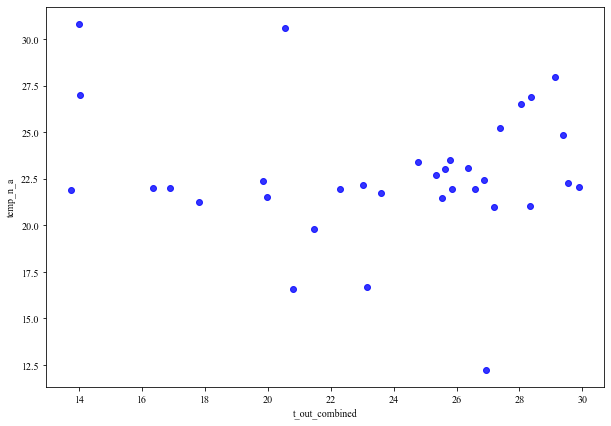

In [51]:
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_SET_NV_a, fit_reg=False, scatter_kws={'color': 'blue'})
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

In [16]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_SET_NV_a['t_out_combined'], df_ACM_SET_NV_a['temp_n_a'], df_ACM_SET_NV_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_SET_NV_a['temp_up_a'].mean() - df_ACM_SET_NV_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.357
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8736
Date:                Thu, 18 Jan 2024   Prob (F-statistic):              0.357
Time:                        10:27:39   Log-Likelihood:                -100.02
No. Observations:                  34   AIC:                             204.0
Df Residuals:                      32   BIC:                             207.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             26.6438     

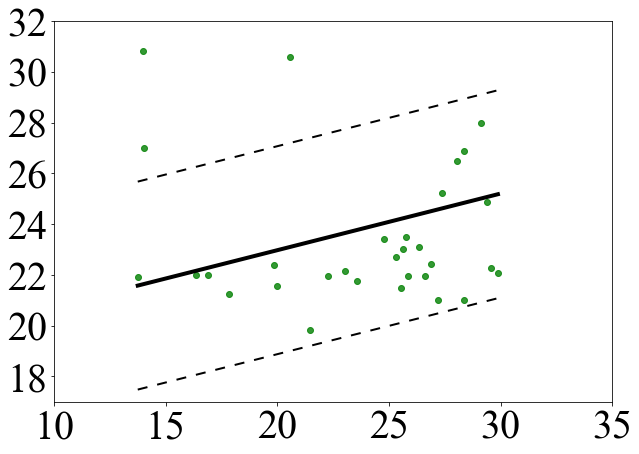

In [63]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_NV_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_SET_NV_a, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig4_a.pdf', format='pdf', bbox_inches='tight')

Accuracy

In [23]:
# # create a new dataframe from df_data, that has all building id in df_bldg_2_NV_office_set_a_a
# df_data_nv_a = df_data_2[df_data_2['building_id'].isin(df_ACM_SET_NV_a['building_id'])].copy()
# df_data_nv_a['up_limit'] = temp_n_a_slope * df_data_nv_a['t_out_combined'] + temp_n_a_intercept + range_a/2
# df_data_nv_a['low_limit'] = temp_n_a_slope * df_data_nv_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# # create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_nv_a['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_nv_a['thermal_sensation'] >= -0.85) & 
#      (df_data_nv_a['thermal_sensation'] <= 0.85) & 
#      (df_data_nv_a['set'] >= df_data_nv_a['low_limit']) & 
#      (df_data_nv_a['set'] <= df_data_nv_a['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_nv_a['thermal_sensation'] < -0.85) | 
#      (df_data_nv_a['thermal_sensation'] > 0.85)) & 
#      ((df_data_nv_a['set'] < df_data_nv_a['low_limit']) | 
#       (df_data_nv_a['set'] > df_data_nv_a['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy on statistically signifiacnt buildings: {:.0f} %'.format(len(df_data_nv_a[df_data_nv_a['accurate_prediction'] == 1])/len(df_data_nv_a)*100))

# create a new dataframe from df_data, that has all building id in df_bldg_2_NV_office_set_a_a
df_data_NV_office = df_data_2[df_data_2['building_id'].isin(df_bldg_2_NV_office['building_id'])].copy()
df_data_NV_office['up_limit'] = temp_n_a_slope * df_data_NV_office['t_out_combined'] + temp_n_a_intercept + range_a/2
df_data_NV_office['low_limit'] = temp_n_a_slope * df_data_NV_office['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_NV_office['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_NV_office['thermal_sensation'] >= -0.85) & 
     (df_data_NV_office['thermal_sensation'] <= 0.85) & 
     (df_data_NV_office['set'] >= df_data_NV_office['low_limit']) & 
     (df_data_NV_office['set'] <= df_data_NV_office['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_NV_office['thermal_sensation'] < -0.85) | 
     (df_data_NV_office['thermal_sensation'] > 0.85)) & 
     ((df_data_NV_office['set'] < df_data_NV_office['low_limit']) | 
      (df_data_NV_office['set'] > df_data_NV_office['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy = len(df_data_NV_office[df_data_NV_office['accurate_prediction'] == 1])/len(df_data_NV_office)
print('Prediction Accraucy of individual TSV on all NV office buildings: {:.0f} %'.format(accuracy*100))

df_bldg_2_NV_office_set_a = df_bldg_2_NV_office.copy()
df_bldg_2_NV_office_set_a['up_limit'] = temp_n_a_slope * df_bldg_2_NV_office_set_a['t_out_combined'] + temp_n_a_intercept + range_a/2
df_bldg_2_NV_office_set_a['low_limit'] = temp_n_a_slope * df_bldg_2_NV_office_set_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit
# when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_2_NV_office_set_a['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_2_NV_office_set_a['thermal_sensation'] >= -0.85) & 
     (df_bldg_2_NV_office_set_a['thermal_sensation'] <= 0.85) & 
     (df_bldg_2_NV_office_set_a['set'] >= df_bldg_2_NV_office_set_a['low_limit']) & 
     (df_bldg_2_NV_office_set_a['set'] <= df_bldg_2_NV_office_set_a['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_2_NV_office_set_a['thermal_sensation'] < -0.85) | 
     (df_bldg_2_NV_office_set_a['thermal_sensation'] > 0.85)) & 
     ((df_bldg_2_NV_office_set_a['set'] < df_bldg_2_NV_office_set_a['low_limit']) | 
      (df_bldg_2_NV_office_set_a['set'] > df_bldg_2_NV_office_set_a['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy = len(df_bldg_2_NV_office_set_a[df_bldg_2_NV_office_set_a['accurate_prediction'] == 1])/len(df_bldg_2_NV_office_set_a)
print('Prediction Accraucy of mean TSV on all NV office buildings: {:.0f} %'.format(accuracy*100))


# calculate the MSE and RMSE of the linear regression of n_temp_a on t_out_combined in df_ACM_SET_NV_a
# calculate the predicted n_temp_a
df_ACM_SET_NV_a['n_temp_a_predicted'] = temp_n_a_slope * df_ACM_SET_NV_a['t_out_combined'] + temp_n_a_intercept
# calculate the residuals_a
df_ACM_SET_NV_a['residuals_a'] = df_ACM_SET_NV_a['temp_n_b'] - df_ACM_SET_NV_a['n_temp_a_predicted']
# calculate the squared residuals_a
df_ACM_SET_NV_a['squared_residuals_a'] = df_ACM_SET_NV_a['residuals_a']**2
# calculate the MSE
MSE = df_ACM_SET_NV_a['squared_residuals_a'].sum()/len(df_ACM_SET_NV_a)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all NV office buildings: 52 %
Prediction Accraucy of mean TSV on all NV office buildings: 69 %
******************************************************************************
RMSE: 3.82


#### Approach (b)

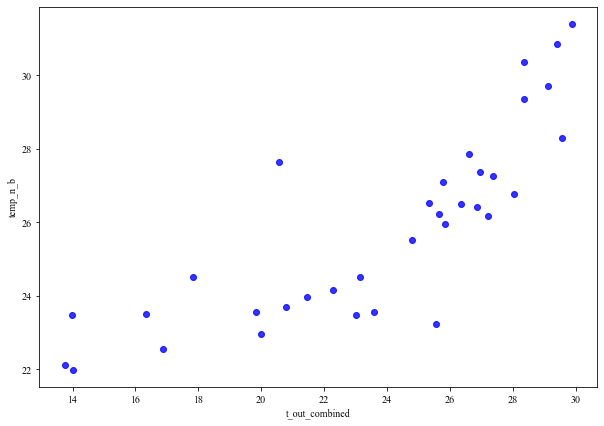

In [65]:
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_NV_b, fit_reg=False, scatter_kws={'color': 'blue'})
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

In [66]:
# conduct weighted ACM_NV regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_SET_NV_b['t_out_combined'], df_ACM_SET_NV_b['temp_n_b'], df_ACM_SET_NV_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_NV regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_SET_NV_b['temp_up_b'].mean() - df_ACM_SET_NV_b['temp_low_b'].mean()
print('ACM_NV comfort zone: {:.2f}'.format(range_b))

p value 0.000
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.715
Model:                            WLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     80.16
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           3.16e-10
Time:                        12:12:28   Log-Likelihood:                -63.432
No. Observations:                  34   AIC:                             130.9
Df Residuals:                      32   BIC:                             133.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.1107     

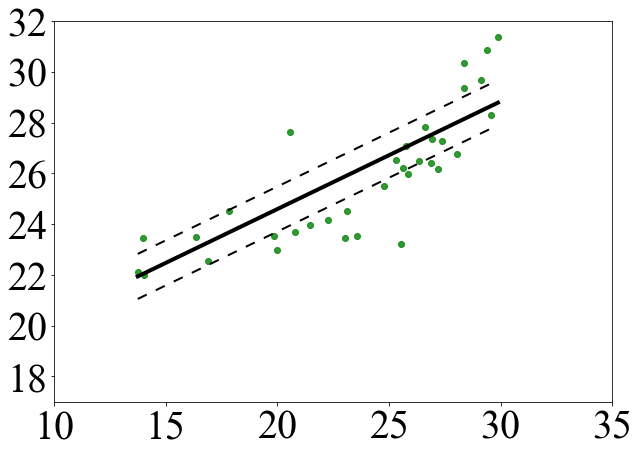

In [67]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_NV_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_NV_b, fit_reg=False, scatter_kws={'color': 'green'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 32)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig4_b.pdf', format='pdf', bbox_inches='tight')

Accuracy

In [25]:
# # create a new dataframe from df_data, that has all building id in df_bldg_2_NV_office_set_b_b
# df_data_nv_b = df_data_2[df_data_2['building_id'].isin(df_ACM_SET_NV_b['building_id'])].copy()
# df_data_nv_b['up_limit'] = temp_n_b_slope * df_data_nv_b['t_out_combined'] + temp_n_b_intercept + range_b/2
# df_data_nv_b['low_limit'] = temp_n_b_slope * df_data_nv_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# # create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_nv_b['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_nv_b['thermal_sensation'] >= -0.85) & 
#      (df_data_nv_b['thermal_sensation'] <= 0.85) & 
#      (df_data_nv_b['set'] >= df_data_nv_b['low_limit']) & 
#      (df_data_nv_b['set'] <= df_data_nv_b['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_nv_b['thermal_sensation'] < -0.85) | 
#      (df_data_nv_b['thermal_sensation'] > 0.85)) & 
#      ((df_data_nv_b['set'] < df_data_nv_b['low_limit']) | 
#       (df_data_nv_b['set'] > df_data_nv_b['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# accuracy = len(df_data_nv_b[df_data_nv_b['accurate_prediction'] == 1])/len(df_data_nv_b)
# print('Prediction Accraucy on statisticaly significant NV building occupants: {:.0f} %'.format(accuracy*100))

df_data_NV_office_b = df_data_2[df_data_2['building_id'].isin(df_bldg_2_NV_office['building_id'])].copy()
df_data_NV_office_b['up_limit'] = temp_n_b_slope * df_data_NV_office_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_data_NV_office_b['low_limit'] = temp_n_b_slope * df_data_NV_office_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_NV_office_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_NV_office_b['thermal_sensation'] >= -0.85) & 
     (df_data_NV_office_b['thermal_sensation'] <= 0.85) & 
     (df_data_NV_office_b['set'] >= df_data_NV_office_b['low_limit']) & 
     (df_data_NV_office_b['set'] <= df_data_NV_office_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_NV_office_b['thermal_sensation'] < -0.85) | 
     (df_data_NV_office_b['thermal_sensation'] > 0.85)) & 
     ((df_data_NV_office_b['set'] < df_data_NV_office_b['low_limit']) | 
      (df_data_NV_office_b['set'] > df_data_NV_office_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_b = len(df_data_NV_office_b[df_data_NV_office_b['accurate_prediction'] == 1])/len(df_data_NV_office_b)
print('Prediction Accraucy of individual TSV on all NV building occupants: {:.0f} %'.format(accuracy_b*100))


df_bldg_2_NV_office_set_b = df_bldg_2_NV_office.copy()
df_bldg_2_NV_office_set_b['up_limit'] = temp_n_b_slope * df_bldg_2_NV_office_set_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_bldg_2_NV_office_set_b['low_limit'] = temp_n_b_slope * df_bldg_2_NV_office_set_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_2_NV_office_set_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_2_NV_office_set_b['thermal_sensation'] >= -0.85) & 
     (df_bldg_2_NV_office_set_b['thermal_sensation'] <= 0.85) & 
     (df_bldg_2_NV_office_set_b['set'] >= df_bldg_2_NV_office_set_b['low_limit']) & 
     (df_bldg_2_NV_office_set_b['set'] <= df_bldg_2_NV_office_set_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_2_NV_office_set_b['thermal_sensation'] < -0.85) | 
     (df_bldg_2_NV_office_set_b['thermal_sensation'] > 0.85)) & 
     ((df_bldg_2_NV_office_set_b['set'] < df_bldg_2_NV_office_set_b['low_limit']) | 
      (df_bldg_2_NV_office_set_b['set'] > df_bldg_2_NV_office_set_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_b = len(df_bldg_2_NV_office_set_b[df_bldg_2_NV_office_set_b['accurate_prediction'] == 1])/len(df_bldg_2_NV_office_set_b)
print('Prediction Accraucy of mean TSV on all NV buildings: {:.0f} %'.format(accuracy_b*100))


# calculate the MSE and RMSE of the linear regression of n_temp_b on t_out_combined in df_ACM_SET_NV_b
# calculate the predicted n_temp_b
df_ACM_SET_NV_b['n_temp_b_predicted'] = temp_n_b_slope * df_ACM_SET_NV_b['t_out_combined'] + temp_n_b_intercept
# calculate the residuals_b
df_ACM_SET_NV_b['residuals_b'] = df_ACM_SET_NV_b['temp_n_b'] - df_ACM_SET_NV_b['n_temp_b_predicted']
# calculate the squared residuals_b
df_ACM_SET_NV_b['squared_residuals_b'] = df_ACM_SET_NV_b['residuals_b']**2
# calculate the MSE
MSE = df_ACM_SET_NV_b['squared_residuals_b'].sum()/len(df_ACM_SET_NV_b)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all NV building occupants: 54 %
Prediction Accraucy of mean TSV on all NV buildings: 45 %
******************************************************************************
RMSE: 1.51


Accuracy of Mean TSV

In [94]:
# df_ACM_SET_NV_b['up_limit'] = temp_n_b_slope * df_ACM_SET_NV_b['t_out_combined'] + temp_n_b_intercept + range_b/2
# df_ACM_SET_NV_b['low_limit'] = temp_n_b_slope * df_ACM_SET_NV_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# # create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_ACM_SET_NV_b['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_ACM_SET_NV_b['thermal_sensation'] >= -0.85) & 
#      (df_ACM_SET_NV_b['thermal_sensation'] <= 0.85) & 
#      (df_ACM_SET_NV_b['set'] >= df_ACM_SET_NV_b['low_limit']) & 
#      (df_ACM_SET_NV_b['set'] <= df_ACM_SET_NV_b['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_ACM_SET_NV_b['thermal_sensation'] < -0.85) | 
#      (df_ACM_SET_NV_b['thermal_sensation'] > 0.85)) & 
#      ((df_ACM_SET_NV_b['set'] < df_ACM_SET_NV_b['low_limit']) | 
#       (df_ACM_SET_NV_b['set'] > df_ACM_SET_NV_b['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy of mean TSV on statistically significant NV buildings: {:.0f} %'.format(len(df_ACM_SET_NV_b[df_ACM_SET_NV_b['accurate_prediction'] == 1])/len(df_ACM_SET_NV_b)*100))


Prediction Accraucy of mean TSV on statistically significant NV buildings: 68 %
Prediction Accraucy of mean TSV on all NV buildings: 65 %


<ipython-input-94-6ee053881677>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_NV_b['up_limit'] = temp_n_b_slope * df_ACM_SET_NV_b['t_out_combined'] + temp_n_b_intercept + range_b/2
<ipython-input-94-6ee053881677>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_NV_b['low_limit'] = temp_n_b_slope * df_ACM_SET_NV_b['t_out_combined'] + temp_n_b_intercept - range_b/2
<ipython-input-94-6ee053881677>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

two buildings near Tout 15C that has high OT neutral temperature, but reasaonble SET neutral temp

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

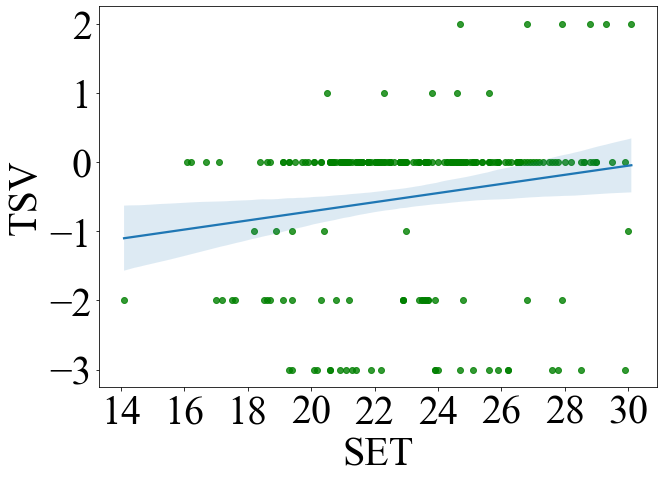

In [35]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='set', y='thermal_sensation', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('SET', fontsize=40)
plt.ylabel('TSV', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

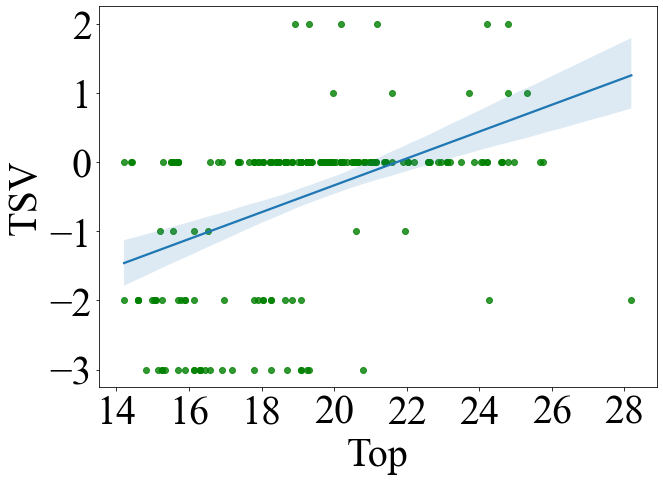

In [41]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='top', y='thermal_sensation', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('Top', fontsize=40)
plt.ylabel('TSV', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

(array([12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

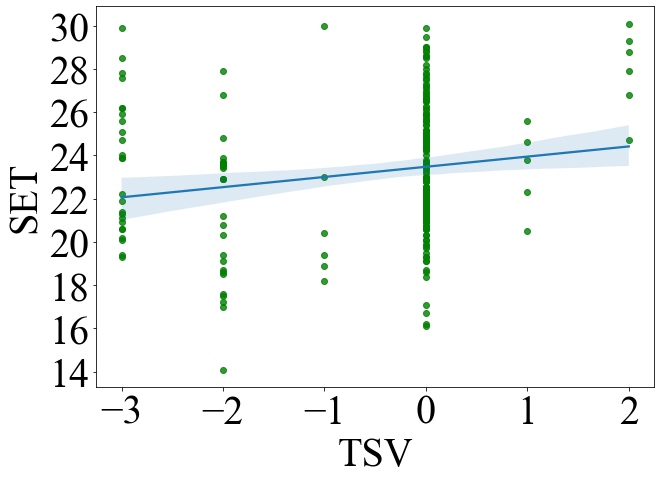

In [36]:
# plot linear regression for building 176 between thermal sensation and set
plt.figure(figsize=(10, 7))
sns.regplot(x='thermal_sensation', y='set', data=df_data_2[df_data_2.building_id == 176], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('TSV', fontsize=40)
plt.ylabel('SET', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

## ACM (SET) for all AC offices

In [16]:
# only keep buildings with 10 < t_out_combined < 33.5
df_ACM_SET_AC_a = df_bldg_2_office_AC_a[(df_bldg_2_office_AC_a['t_out_combined'] >= 10) & (df_bldg_2_office_AC_a['t_out_combined'] <= 33.5)]
df_ACM_SET_AC_b = df_bldg_2_office_AC_b[(df_bldg_2_office_AC_b['t_out_combined'] >= 10) & (df_bldg_2_office_AC_b['t_out_combined'] <= 33.5)]
print("Total buildings for Approach (a) ACM_AC:", len(df_ACM_SET_AC_a))
print("Total buildings for Approach (b) ACM_AC:", len(df_ACM_SET_AC_b))

Total buildings for Approach (a) ACM_AC: 34
Total buildings for Approach (b) ACM_AC: 34


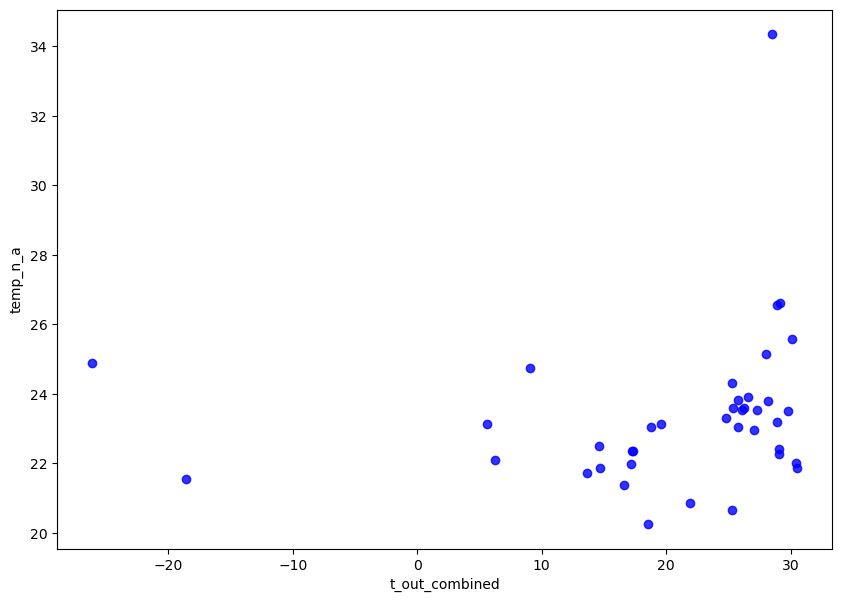

In [17]:
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_bldg_2_office_AC_a, fit_reg=False, scatter_kws={'color': 'blue'})
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

In [18]:
# select the row where the temp_n_a is higher than 30
df_bldg_2_office_AC_a[df_bldg_2_office_AC_a['temp_n_a'] > 30]

,building_id,t_out_combined,top,set,thermal_sensation,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
513,737,28.489431,25.026042,25.511458,-0.739583,99,Air Conditioned,office,2.1,0.08371,0.527388,-2.875156,25.901505,34.346489,25.901505,44.500552,26.349785,24.192426,25.453226


(array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, -3.5, '−3.5'),
  Text(0, -3.0, '−3.0'),
  Text(0, -2.5, '−2.5'),
  Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

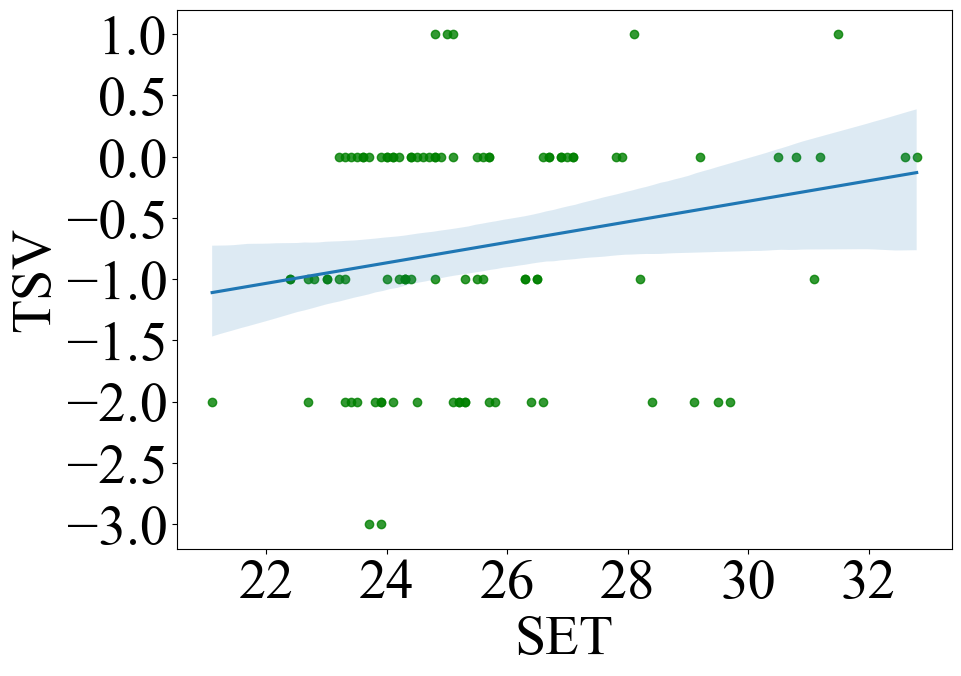

In [19]:
# plot the TSV vs. SET for building 737 from df_data
plt.figure(figsize=(10, 7))
sns.regplot(x='set', y='thermal_sensation', data=df_data_2[df_data_2.building_id == 737], fit_reg=True, scatter_kws={'color': 'green'})
plt.xlabel('SET', fontsize=40)
plt.ylabel('TSV', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)


Approach (a)

In [21]:
# conduct weighted ACM regression line based on approach (a)
temp_n_a_intercept, temp_n_a_slope = weighted_regression(df_ACM_SET_AC_a['t_out_combined'], df_ACM_SET_AC_a['temp_n_a'], df_ACM_SET_AC_a['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM regression line slope: {:.2f}'.format(temp_n_a_slope))
print('ACM regression line slope: {:.2f}'.format(temp_n_a_intercept))

# calculate the mean comfort zone
range_a = df_ACM_SET_AC_a['temp_up_a'].mean() - df_ACM_SET_AC_a['temp_low_a'].mean()
print('ACM comfort zone: {:.2f}'.format(range_a))

p value 0.002
                            WLS Regression Results                            
Dep. Variable:               temp_n_a   R-squared:                       0.272
Model:                            WLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     11.93
Date:                Thu, 18 Jan 2024   Prob (F-statistic):            0.00158
Time:                        12:38:21   Log-Likelihood:                -76.503
No. Observations:                  34   AIC:                             157.0
Df Residuals:                      32   BIC:                             160.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.5132     

/opt/anaconda3/envs/causal/lib/python3.11/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


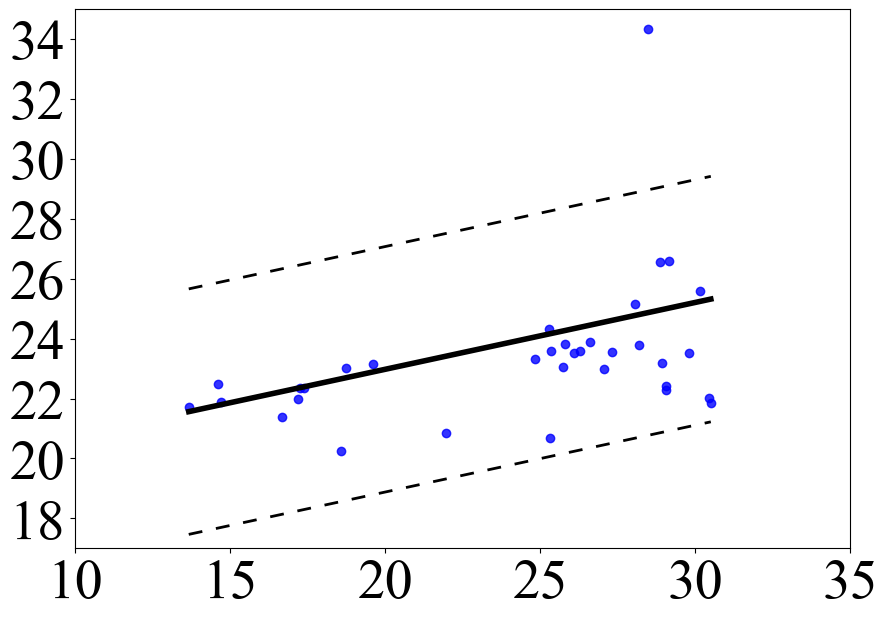

In [22]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_AC_a['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept + range_a/2
low_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept - range_a/2
middle_line = temp_n_a_slope * t_out_combined + temp_n_a_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_a', data=df_ACM_SET_AC_a, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig5_a.pdf', format='pdf', bbox_inches='tight')

Accuracy

In [40]:
# # create a new dataframe from df_data, that has all building id in df_bldg_nv_a
# df_data_AC_office_a = df_data_2[df_data_2['building_id'].isin(df_ACM_SET_AC_a['building_id'])].copy()
# df_data_AC_office_a['up_limit'] = temp_n_a_slope * df_data_AC_office_a['t_out_combined'] + temp_n_a_intercept + range_a/2
# df_data_AC_office_a['low_limit'] = temp_n_a_slope * df_data_AC_office_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# # create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_AC_office_a['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_AC_office_a['thermal_sensation'] >= -0.85) & 
#      (df_data_AC_office_a['thermal_sensation'] <= 0.85) & 
#      (df_data_AC_office_a['set'] >= df_data_AC_office_a['low_limit']) & 
#      (df_data_AC_office_a['set'] <= df_data_AC_office_a['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_AC_office_a['thermal_sensation'] < -0.85) | 
#      (df_data_AC_office_a['thermal_sensation'] > 0.85)) & 
#      ((df_data_AC_office_a['set'] < df_data_AC_office_a['low_limit']) | 
#       (df_data_AC_office_a['set'] > df_data_AC_office_a['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy: {:.0f} %'.format(len(df_data_AC_office_a[df_data_AC_office_a['accurate_prediction'] == 1])/len(df_data_AC_office_a)*100))


df_data_AC_office_a = df_data_2[df_data_2['building_id'].isin(df_bldg_2_AC_office['building_id'])].copy()
df_data_AC_office_a['up_limit'] = temp_n_a_slope * df_data_AC_office_a['t_out_combined'] + temp_n_a_intercept + range_a/2
df_data_AC_office_a['low_limit'] = temp_n_a_slope * df_data_AC_office_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_AC_office_a['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_AC_office_a['thermal_sensation'] >= -0.85) & 
     (df_data_AC_office_a['thermal_sensation'] <= 0.85) & 
     (df_data_AC_office_a['set'] >= df_data_AC_office_a['low_limit']) & 
     (df_data_AC_office_a['set'] <= df_data_AC_office_a['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_AC_office_a['thermal_sensation'] < -0.85) | 
     (df_data_AC_office_a['thermal_sensation'] > 0.85)) & 
     ((df_data_AC_office_a['set'] < df_data_AC_office_a['low_limit']) | 
      (df_data_AC_office_a['set'] > df_data_AC_office_a['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
print('Prediction Accraucy of individual TSV on all AC office buildings: {:.0f} %'.format(len(df_data_AC_office_a[df_data_AC_office_a['accurate_prediction'] == 1])/len(df_data_AC_office_a)*100))

df_bldg_2_AC_office_set_a = df_bldg_2_AC_office.copy()
df_bldg_2_AC_office_set_a['up_limit'] = temp_n_a_slope * df_bldg_2_AC_office_set_a['t_out_combined'] + temp_n_a_intercept + range_a/2
df_bldg_2_AC_office_set_a['low_limit'] = temp_n_a_slope * df_bldg_2_AC_office_set_a['t_out_combined'] + temp_n_a_intercept - range_a/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit
# when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_2_AC_office_set_a['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_2_AC_office_set_a['thermal_sensation'] >= -0.85) & 
     (df_bldg_2_AC_office_set_a['thermal_sensation'] <= 0.85) & 
     (df_bldg_2_AC_office_set_a['set'] >= df_bldg_2_AC_office_set_a['low_limit']) & 
     (df_bldg_2_AC_office_set_a['set'] <= df_bldg_2_AC_office_set_a['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_2_AC_office_set_a['thermal_sensation'] < -0.85) | 
     (df_bldg_2_AC_office_set_a['thermal_sensation'] > 0.85)) & 
     ((df_bldg_2_AC_office_set_a['set'] < df_bldg_2_AC_office_set_a['low_limit']) | 
      (df_bldg_2_AC_office_set_a['set'] > df_bldg_2_AC_office_set_a['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy = len(df_bldg_2_AC_office_set_a[df_bldg_2_AC_office_set_a['accurate_prediction'] == 1])/len(df_bldg_2_AC_office_set_a)
print('Prediction Accraucy of mean TSV on all AC office buildings: {:.0f} %'.format(accuracy*100))


# calculate the MSE and RMSE of the linear regression of n_temp_a on t_out_combined in df_ACM_SET_AC_a
# calculate the predicted n_temp_a
df_ACM_SET_AC_a['n_temp_a_predicted'] = temp_n_a_slope * df_ACM_SET_AC_a['t_out_combined'] + temp_n_a_intercept
# calculate the residuals_a
df_ACM_SET_AC_a['residuals_a'] = df_ACM_SET_AC_a['temp_n_b'] - df_ACM_SET_AC_a['n_temp_a_predicted']
# calculate the squared residuals_a
df_ACM_SET_AC_a['squared_residuals_a'] = df_ACM_SET_AC_a['residuals_a']**2
# calculate the MSE
MSE = df_ACM_SET_AC_a['squared_residuals_a'].sum()/len(df_ACM_SET_AC_a)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all AC office buildings: 48 %
Prediction Accraucy of mean TSV on all AC office buildings: 80 %
******************************************************************************
RMSE: 1.52


<ipython-input-40-6659090eccc7>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_AC_a['n_temp_a_predicted'] = temp_n_a_slope * df_ACM_SET_AC_a['t_out_combined'] + temp_n_a_intercept
<ipython-input-40-6659090eccc7>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_AC_a['residuals_a'] = df_ACM_SET_AC_a['temp_n_b'] - df_ACM_SET_AC_a['n_temp_a_predicted']
<ipython-input-40-6659090eccc7>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Approach (b)

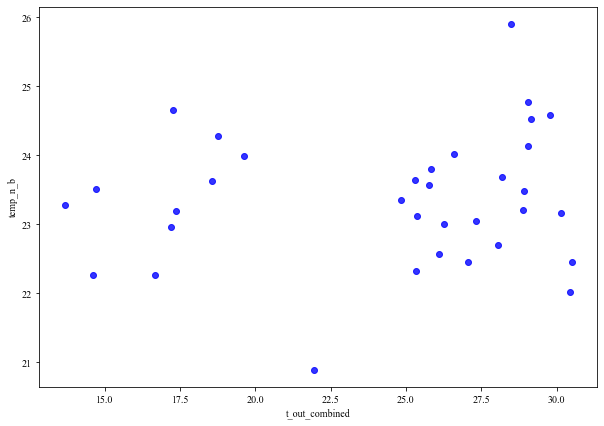

In [49]:
plt.figure(figsize=(10, 7))
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_AC_b, fit_reg=False, scatter_kws={'color': 'blue'})
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.savefig('figs/ACM_NV_neutral_a.pdf', format='pdf', bbox_inches='tight')

In [23]:
# conduct weighted ACM_AC regression line based on approach (b)
temp_n_b_intercept, temp_n_b_slope = weighted_regression(df_ACM_SET_AC_b['t_out_combined'], df_ACM_SET_AC_b['temp_n_b'], df_ACM_SET_AC_b['records'])
# print the fitted line slope and intercept
print("******************************************************************************")
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_slope))
print('ACM_AC regression line slope: {:.2f}'.format(temp_n_b_intercept))

# calculate the mean comfort zone
range_b = df_ACM_SET_AC_b['temp_up_b'].mean() - df_ACM_SET_AC_b['temp_low_b'].mean()
print('ACM_AC comfort zone: {:.2f}'.format(range_b))

p value 0.227
                            WLS Regression Results                            
Dep. Variable:               temp_n_b   R-squared:                       0.045
Model:                            WLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.517
Date:                Thu, 18 Jan 2024   Prob (F-statistic):              0.227
Time:                        12:38:28   Log-Likelihood:                -47.522
No. Observations:                  34   AIC:                             99.04
Df Residuals:                      32   BIC:                             102.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.7922     

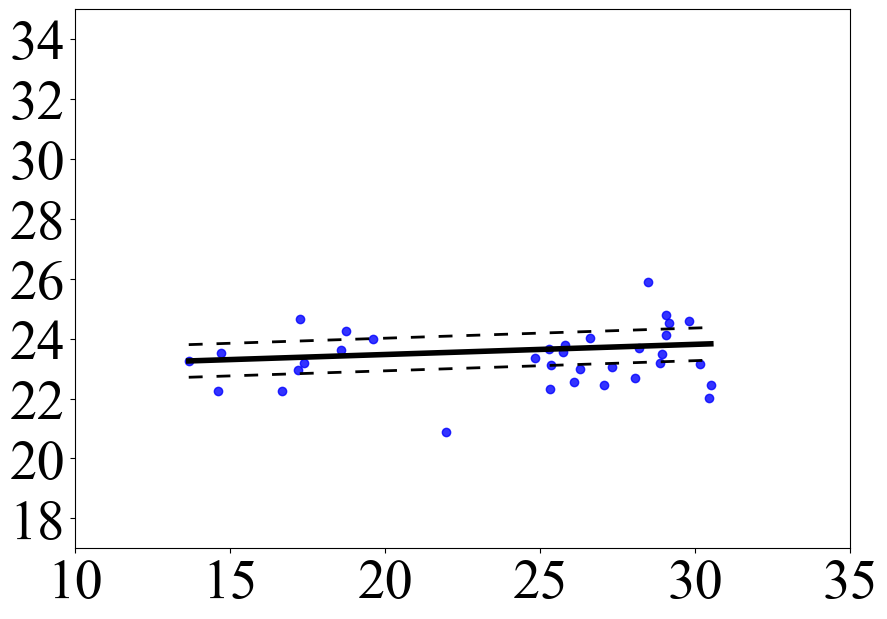

In [24]:
# sort the data points by t_out_combined
t_out_combined = np.array(df_ACM_SET_AC_b['t_out_combined'])
sort_index = np.argsort(t_out_combined)
t_out_combined = t_out_combined[sort_index]
up_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept + range_b/2
low_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept - range_b/2
middle_line = temp_n_b_slope * t_out_combined + temp_n_b_intercept

# plot data points
plt.figure(figsize=(10, 7))
plt.plot(t_out_combined, middle_line, color='black', linewidth=4)
sns.regplot(x='t_out_combined', y='temp_n_b', data=df_ACM_SET_AC_b, fit_reg=False, scatter_kws={'color': 'blue'})
plt.plot(t_out_combined, up_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.plot(t_out_combined, low_line, color='black', linewidth=2, linestyle='--', dashes=(5, 5))
plt.xlabel('', fontsize=40)
plt.ylabel('', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.xlim(10, 35)
plt.ylim(17, 35)
plt.grid(False)
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig('figs/fig5_b.pdf', format='pdf', bbox_inches='tight')

accuracy

In [42]:
# # create a new dataframe from df_data, that has all building id in df_bldg_nv_b
# df_data_AC_b = df_data_2[df_data_2['building_id'].isin(df_ACM_SET_AC_b['building_id'])].copy()
# df_data_AC_b['up_limit'] = temp_n_b_slope * df_data_AC_b['t_out_combined'] + temp_n_b_intercept + range_b/2
# df_data_AC_b['low_limit'] = temp_n_b_slope * df_data_AC_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# # create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
# df_data_AC_b['accurate_prediction'] = np.where(
#     # Case 1: Comfortable when within range
#     ((df_data_AC_b['thermal_sensation'] >= -0.85) & 
#      (df_data_AC_b['thermal_sensation'] <= 0.85) & 
#      (df_data_AC_b['set'] >= df_data_AC_b['low_limit']) & 
#      (df_data_AC_b['set'] <= df_data_AC_b['up_limit'])) |
#     # Case 2: Uncomfortable when out of range
#     ((df_data_AC_b['thermal_sensation'] < -0.85) | 
#      (df_data_AC_b['thermal_sensation'] > 0.85)) & 
#      ((df_data_AC_b['set'] < df_data_AC_b['low_limit']) | 
#       (df_data_AC_b['set'] > df_data_AC_b['up_limit'])),
#     1,  # Accurate prediction
#     0)   # Inaccurate prediction
# # count the number of rows that have within_range == 1
# print('Prediction Accraucy on statisticall significant bulidings: {:.0f} %'.format(len(df_data_AC_b[df_data_AC_b['accurate_prediction'] == 1])/len(df_data_AC_b)*100))


df_data_AC_b = df_data_2[df_data_2['building_id'].isin(df_bldg_2_AC_office['building_id'])].copy()
df_data_AC_b['up_limit'] = temp_n_b_slope * df_data_AC_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_data_AC_b['low_limit'] = temp_n_b_slope * df_data_AC_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_data_AC_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_data_AC_b['thermal_sensation'] >= -0.85) & 
     (df_data_AC_b['thermal_sensation'] <= 0.85) & 
     (df_data_AC_b['set'] >= df_data_AC_b['low_limit']) & 
     (df_data_AC_b['set'] <= df_data_AC_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_data_AC_b['thermal_sensation'] < -0.85) | 
     (df_data_AC_b['thermal_sensation'] > 0.85)) & 
     ((df_data_AC_b['set'] < df_data_AC_b['low_limit']) | 
      (df_data_AC_b['set'] > df_data_AC_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
print('Prediction Accraucy of individual TSV on all bulidings: {:.0f} %'.format(len(df_data_AC_b[df_data_AC_b['accurate_prediction'] == 1])/len(df_data_AC_b)*100))

df_bldg_2_AC_office_set_b = df_bldg_2_AC_office.copy()
df_bldg_2_AC_office_set_b['up_limit'] = temp_n_b_slope * df_bldg_2_AC_office_set_b['t_out_combined'] + temp_n_b_intercept + range_b/2
df_bldg_2_AC_office_set_b['low_limit'] = temp_n_b_slope * df_bldg_2_AC_office_set_b['t_out_combined'] + temp_n_b_intercept - range_b/2
# create a new column, for each row, assign the value of 1 if the set is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the set is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
df_bldg_2_AC_office_set_b['accurate_prediction'] = np.where(
    # Case 1: Comfortable when within range
    ((df_bldg_2_AC_office_set_b['thermal_sensation'] >= -0.85) & 
     (df_bldg_2_AC_office_set_b['thermal_sensation'] <= 0.85) & 
     (df_bldg_2_AC_office_set_b['set'] >= df_bldg_2_AC_office_set_b['low_limit']) & 
     (df_bldg_2_AC_office_set_b['set'] <= df_bldg_2_AC_office_set_b['up_limit'])) |
    # Case 2: Uncomfortable when out of range
    ((df_bldg_2_AC_office_set_b['thermal_sensation'] < -0.85) | 
     (df_bldg_2_AC_office_set_b['thermal_sensation'] > 0.85)) & 
     ((df_bldg_2_AC_office_set_b['set'] < df_bldg_2_AC_office_set_b['low_limit']) | 
      (df_bldg_2_AC_office_set_b['set'] > df_bldg_2_AC_office_set_b['up_limit'])),
    1,  # Accurate prediction
    0)   # Inaccurate prediction
# count the number of rows that have within_range == 1
accuracy_b = len(df_bldg_2_AC_office_set_b[df_bldg_2_AC_office_set_b['accurate_prediction'] == 1])/len(df_bldg_2_AC_office_set_b)
print('Prediction Accraucy of mean TSV on all NV buildings: {:.0f} %'.format(accuracy_b*100))


# calculate the MSE and RMSE of the linear regression of n_temp_b on t_out_combined in df_ACM_SET_AC_b
# calculate the predicted n_temp_b
df_ACM_SET_AC_b['n_temp_b_predicted'] = temp_n_b_slope * df_ACM_SET_AC_b['t_out_combined'] + temp_n_b_intercept
# calculate the residuals
df_ACM_SET_AC_b['residuals'] = df_ACM_SET_AC_b['temp_n_b'] - df_ACM_SET_AC_b['n_temp_b_predicted']
# calculate the squared residuals
df_ACM_SET_AC_b['squared_residuals'] = df_ACM_SET_AC_b['residuals']**2
# calculate the MSE
MSE = df_ACM_SET_AC_b['squared_residuals'].sum()/len(df_ACM_SET_AC_b)
print("******************************************************************************")
# print('MSE: {:.2f}'.format(MSE))
# calculate the RMSE
RMSE = np.sqrt(MSE)
print('RMSE: {:.2f}'.format(RMSE))

Prediction Accraucy of individual TSV on all bulidings: 54 %
Prediction Accraucy of mean TSV on all NV buildings: 50 %
******************************************************************************
RMSE: 0.97


<ipython-input-42-1528a115ea7f>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_AC_b['n_temp_b_predicted'] = temp_n_b_slope * df_ACM_SET_AC_b['t_out_combined'] + temp_n_b_intercept
<ipython-input-42-1528a115ea7f>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_SET_AC_b['residuals'] = df_ACM_SET_AC_b['temp_n_b'] - df_ACM_SET_AC_b['n_temp_b_predicted']
<ipython-input-42-1528a115ea7f>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

## PMV

In [84]:
# check nan values in columns of df_data_1: ta, rh, vel, tr, met, clo
print(df_data_1['ta'].isna().sum())
print(df_data_1['rh'].isna().sum())
print(df_data_1['vel'].isna().sum())
print(df_data_1['tr'].isna().sum())
print(df_data_1['met'].isna().sum())
print(df_data_1['clo'].isna().sum())


0
0
0
0
0
0


In [14]:
df_bldg_2_AC_office

,building_id,t_out_combined,top,set,thermal_sensation,records,cooling_type,building_type,database,slope_a,slope_b,intercept_a,intercept_b,temp_n_a,temp_n_b,temp_up_a,temp_up_b,temp_low_a,temp_low_b
1,2,13.995833,22.328590,23.616000,0.020000,83,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.583480,23.178237,23.694118,0.252941,85,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9.048210,22.095310,22.271875,-0.063281,128,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,17.668114,22.829931,22.606250,0.148958,96,Air Conditioned,office,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,14.604240,22.333478,22.240789,-0.047368,152,Air Conditioned,office,1.0,0.181981,0.333992,-4.094772,22.256610,22.501083,22.256610,27.171897,22.540503,17.830268,21.972717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,733,22.604066,25.806667,26.139394,0.133333,167,Air Conditioned,office,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,735,29.154568,24.376592,24.284554,-0.377389,629,Air Conditioned,office,2.1,0.162655,0.649373,-4.327395,24.529620,26.604731,24.529620,31.830513,25.081587,21.378949,23.977653
513,737,28.489431,25.026042,25.511458,-0.739583,99,Air Conditioned,office,2.1,0.083710,0.527388,-2.875156,25.901505,34.346489,25.901505,44.500552,26.349785,24.192426,25.453226
514,738,28.907595,24.370573,24.519792,-0.906250,387,Air Conditioned,office,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Fixed values from your dataset, converted to scalars
tr = df_bldg_2['tr'].mean()
rh = df_bldg_2['rh'].mean()
vel = df_bldg_2['vel'].mean()
met = df_bldg_2['met'].mean()
clo = df_bldg_2['clo'].mean()

# Objective function to find ta for a given PMV target
def objective(ta, pmv_target):
    # Calculate PMV for the current ta
    current_pmv = pmv(ta, tr, vel, rh, met, clo, standard='ASHRAE')
    # Objective is to minimize the square of the difference between current PMV and target PMV
    return (current_pmv - pmv_target)**2

# Use minimize_scalar to find the neutral air temperature that results in PMV=0
result_neutral = minimize_scalar(objective, bounds=(15, 35), args=(0,), method='bounded')
t_n_PMV = result_neutral.x

# Use minimize_scalar to find the air temperature that results in PMV=0.85
result_up = minimize_scalar(objective, bounds=(15, 35), args=(0.85,), method='bounded')
up_ta = result_up.x

# Use minimize_scalar to find the air temperature that results in PMV=-0.85
result_low = minimize_scalar(objective, bounds=(15, 35), args=(-0.85,), method='bounded')
low_ta = result_low.x

print(f"The neutral SET for PMV=0 is: {t_o(t_n_PMV, tr, vel, standard='ASHRAE'):.2f} °C")
print(f"The upper SET for PMV=0.85 is: {t_o(up_ta, tr, vel, standard='ASHRAE'):.2f} °C")
print(f"The lower SET for PMV=-0.85 is: {t_o(low_ta, tr, vel, standard='ASHRAE'):.2f} °C")

In [ ]:
def neutral_temp_PMV(bldg):
    try:
        # Extract the mean values from the building DataFrame
        ta = bldg['ta'].mean()
        tr = bldg['tr'].mean()
        rh = bldg['rh'].mean()
        vel = bldg['vel'].mean()
        met = bldg['met'].mean()
        clo = bldg['clo'].mean()

        # Objective function to find ta for a given PMV target
        def objective(ta, pmv_target):
            # Calculate PMV for the current ta
            current_pmv = pmv(ta, tr, vel, rh, met, clo, standard='ASHRAE')
            # Objective is to minimize the square of the difference between current PMV and target PMV
            return (current_pmv - pmv_target)**2

        # Find the neutral air temperature that results in PMV=0
        result_neutral = minimize_scalar(objective, bounds=(15, 35), args=(0,), method='bounded')
        ta_n_PMV = result_neutral.x

        # Find the air temperature that results in PMV=0.85
        result_up = minimize_scalar(objective, bounds=(15, 35), args=(0.85,), method='bounded')
        ta_up_PMV = result_up.x

        # Find the air temperature that results in PMV=-0.85
        result_low = minimize_scalar(objective, bounds=(15, 35), args=(-0.85,), method='bounded')
        ta_low_PMV = result_low.x

        # Calculate the SET
        SET_n_PMV = set_tmp(ta_n_PMV, tr, vel, rh, met, clo)
        SET_up_PMV = set_tmp(ta_up_PMV, tr, vel, rh, met, clo)
        SET_low_PMV = set_tmp(ta_low_PMV, tr, vel, rh, met, clo)

        return [SET_n_PMV, SET_up_PMV, SET_low_PMV]

    except Exception as e:
        print(f"An error occurred: {e}")
        return np.nan

## For all buildings

optimize intercept and range, with a fixed slope as 0

In [91]:
# create a new dataframe from df_data, that has all building id in df_bldg_nv_a
df_data_3 = df_data_2
results = []

for i in np.arange(15, 35, 0.5):
    intercept_3 = i
    for j in np.arange(10, 0, -0.5):
        range_3 = j
        df_data_3['up_limit'] = df_data_3['t_out_combined'] + intercept_3 + range_3/2
        df_data_3['low_limit'] = df_data_3['t_out_combined'] + intercept_3 - range_3/2
        # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
        df_data_3['accurate_prediction'] = np.where(
            # Case 1: Comfortable when within range
            ((df_data_3['thermal_sensation'] >= -0.85) & 
            (df_data_3['thermal_sensation'] <= 0.85) & 
            (df_data_3['top'] >= df_data_3['low_limit']) & 
            (df_data_3['top'] <= df_data_3['up_limit'])) |
            # Case 2: Uncomfortable when out of range
            ((df_data_3['thermal_sensation'] < -0.85) | 
            (df_data_3['thermal_sensation'] > 0.85)) & 
            ((df_data_3['top'] < df_data_3['low_limit']) | 
            (df_data_3['top'] > df_data_3['up_limit'])),
            1,  # Accurate prediction
            0)   # Inaccurate prediction
        
        df_data_3['accurate_prediction_SET'] = np.where(
            # Case 1: Comfortable when within range
            ((df_data_3['thermal_sensation'] >= -0.85) & 
            (df_data_3['thermal_sensation'] <= 0.85) & 
            (df_data_3['set'] >= df_data_3['low_limit']) & 
            (df_data_3['set'] <= df_data_3['up_limit'])) |
            # Case 2: Uncomfortable when out of range
            ((df_data_3['thermal_sensation'] < -0.85) | 
            (df_data_3['thermal_sensation'] > 0.85)) & 
            ((df_data_3['set'] < df_data_3['low_limit']) | 
            (df_data_3['set'] > df_data_3['up_limit'])),
            1,  # Accurate prediction
            0)   # Inaccurate prediction
        
        # count the number of rows that have within_range == 1
        accuracy = len(df_data_3[df_data_3['accurate_prediction'] == 1])/len(df_data_3)
        accuracy_SET = len(df_data_3[df_data_3['accurate_prediction_SET'] == 1])/len(df_data_3)
        results.append({'Intercept': intercept_3, 'Range': range_3, 'Accuracy OT': accuracy, 'Accuracy SET': accuracy_SET})
        
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

In [92]:
# select the row that has the highest accuracy
results_df[results_df['Accuracy OT'] == results_df['Accuracy OT'].max()]

,Intercept,Range,Accuracy OT,Accuracy SET
229,20.5,5.5,0.569278,0.568404
265,21.5,7.5,0.569278,0.568708
273,21.5,3.5,0.569278,0.569240
283,22.0,8.5,0.569278,0.568708
294,22.0,3.0,0.569278,0.569240
301,22.5,9.5,0.569278,0.568670
309,22.5,5.5,0.569278,0.569544
310,22.5,5.0,0.569278,0.569506
311,22.5,4.5,0.569278,0.569354
327,23.0,6.5,0.569278,0.569544


In [93]:
# select the row that has the highest accuracy
results_df[results_df['Accuracy SET'] == results_df['Accuracy SET'].max()]

,Intercept,Range,Accuracy OT,Accuracy SET
270,21.5,5.0,0.568822,0.570076


also optimize the slope of SET

In [95]:
# create a new dataframe from df_data, that has all building id in df_bldg_nv_a
df_data_3 = df_data_2
results = []

for s in np.arange(0.1, 1.1, 0.1):
    slope_3 = s
    for i in np.arange(15, 35, 0.1):
        intercept_3 = i
        for j in np.arange(10, 0, -0.1):
            range_3 = j
            df_data_3['up_limit'] = slope_3 * df_data_3['t_out_combined'] + intercept_3 + range_3/2
            df_data_3['low_limit'] = slope_3 * df_data_3['t_out_combined'] + intercept_3 - range_3/2
            
            df_data_3['accurate_prediction_SET'] = np.where(
                # Case 1: Comfortable when within range
                ((df_data_3['thermal_sensation'] >= -0.85) & 
                (df_data_3['thermal_sensation'] <= 0.85) & 
                (df_data_3['set'] >= df_data_3['low_limit']) & 
                (df_data_3['set'] <= df_data_3['up_limit'])) |
                # Case 2: Uncomfortable when out of range
                ((df_data_3['thermal_sensation'] < -0.85) | 
                (df_data_3['thermal_sensation'] > 0.85)) & 
                ((df_data_3['set'] < df_data_3['low_limit']) | 
                (df_data_3['set'] > df_data_3['up_limit'])),
                1,  # Accurate prediction
                0)   # Inaccurate prediction
            
            # count the number of rows that have within_range == 1
            accuracy = len(df_data_3[df_data_3['accurate_prediction'] == 1])/len(df_data_3)
            accuracy_SET = len(df_data_3[df_data_3['accurate_prediction_SET'] == 1])/len(df_data_3)
            results.append({'Slope': slope_3, 'Intercept': intercept_3, 'Range': range_3, 'Accuracy OT': accuracy, 'Accuracy SET': accuracy_SET})
            
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

In [98]:
results_df[results_df['Accuracy SET'] == results_df['Accuracy SET'].max()]

,Slope,Intercept,Range,Accuracy OT,Accuracy SET
186551,1.0,21.5,4.9,0.568214,0.570114
186648,1.0,21.6,5.2,0.568214,0.570114
186649,1.0,21.6,5.1,0.568214,0.570114
186650,1.0,21.6,5.0,0.568214,0.570114


## Mean TSV, NV buildings

Optimize intercept and range, and slope (approach b's result is slope = 0.42 and intercept 11.)

In [108]:
# create a new dataframe from df_data, that has all building id in df_bldg_nv_a
df_bldg_nv = df_bldg_1[df_bldg_1['cooling_type'] == 'Naturally Ventilated']

results = []
for s in np.arange(0.1, 1.1, 0.1):
    slope_4 = s
    for i in np.arange(15, 35, 0.5):
        intercept_4 = i
        for j in np.arange(10, 0, -0.5):
            range_4 = j
            df_bldg_nv['up_limit'] = slope_4 * df_bldg_nv['t_out_combined'] + intercept_4 + range_4/2
            df_bldg_nv['low_limit'] = slope_4 * df_bldg_nv['t_out_combined'] + intercept_4 - range_4/2
            # create a new column, for each row, assign the value of 1 if the top is within up_limit and low_limit when thermal_sensation is within +0.85 and -0.85, or the top is not within up_limit and low_limit when thermal_sensation is not within +0.85 and -0.85, otherwise assign the value of 0
            df_bldg_nv['accurate_prediction'] = np.where(
                # Case 1: Comfortable when within range
                ((df_bldg_nv['thermal_sensation'] >= -0.85) & 
                (df_bldg_nv['thermal_sensation'] <= 0.85) & 
                (df_bldg_nv['top'] >= df_bldg_nv['low_limit']) & 
                (df_bldg_nv['top'] <= df_bldg_nv['up_limit'])) |
                # Case 2: Uncomfortable when out of range
                ((df_bldg_nv['thermal_sensation'] < -0.85) | 
                (df_bldg_nv['thermal_sensation'] > 0.85)) & 
                ((df_bldg_nv['top'] < df_bldg_nv['low_limit']) | 
                (df_bldg_nv['top'] > df_bldg_nv['up_limit'])),
                1,  # Accurate prediction
                0)   # Inaccurate prediction
            
            df_bldg_nv['accurate_prediction_SET'] = np.where(
                # Case 1: Comfortable when within range
                ((df_bldg_nv['thermal_sensation'] >= -0.85) & 
                (df_bldg_nv['thermal_sensation'] <= 0.85) & 
                (df_bldg_nv['set'] >= df_bldg_nv['low_limit']) & 
                (df_bldg_nv['set'] <= df_bldg_nv['up_limit'])) |
                # Case 2: Uncomfortable when out of range
                ((df_bldg_nv['thermal_sensation'] < -0.85) | 
                (df_bldg_nv['thermal_sensation'] > 0.85)) & 
                ((df_bldg_nv['set'] < df_bldg_nv['low_limit']) | 
                (df_bldg_nv['set'] > df_bldg_nv['up_limit'])),
                1,  # Accurate prediction
                0)   # Inaccurate prediction
            
            # count the number of rows that have within_range == 1
            accuracy = len(df_bldg_nv[df_bldg_nv['accurate_prediction'] == 1])/len(df_bldg_nv)
            accuracy_SET = len(df_bldg_nv[df_bldg_nv['accurate_prediction_SET'] == 1])/len(df_bldg_nv)
            results.append({'Slope': slope_4, 'Intercept': intercept_4, 'Range': range_4, 'Accuracy OT': accuracy, 'Accuracy SET': accuracy_SET})
            
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

<ipython-input-108-b468dd268789>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bldg_nv['up_limit'] = slope_4 * df_bldg_nv['t_out_combined'] + intercept_4 + range_4/2
<ipython-input-108-b468dd268789>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bldg_nv['low_limit'] = slope_4 * df_bldg_nv['t_out_combined'] + intercept_4 - range_4/2
<ipython-input-108-b468dd268789>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [109]:
results_df[results_df['Accuracy OT'] == results_df['Accuracy OT'].max()]

,Slope,Intercept,Range,Accuracy OT,Accuracy SET
3202,0.5,15.0,9.0,0.720812,0.675127


In [110]:
results_df[results_df['Accuracy SET'] == results_df['Accuracy SET'].max()]

,Slope,Intercept,Range,Accuracy OT,Accuracy SET
3240,0.5,16.0,10.0,0.700508,0.71066
3260,0.5,16.5,10.0,0.690355,0.71066


Also optimize slope